In [ ]:
import ast
import datetime
import math
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-learn - preprocessing
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# XGBoost
!pip install xgboost
from xgboost import XGBClassifier


Defaulting to user installation because normal site-packages is not writeable


Coloring

In [2]:
from matplotlib.colors import LinearSegmentedColormap
def make_single_color_cmap(hex_color, name):
    return LinearSegmentedColormap.from_list(name, ["#FFFFFF", hex_color])

colors = {
    'cmap1': '#CC6677',  # mem
    'cmap2': '#44AA99',  # gpu
    'cmap3': '#AA4499',  # power
}

In [ ]:
vasp_data = pd.read_parquet('VASP_march_jobs_ai_fixed.parquet')

Binning Resource Utilization

In [4]:
def bin_power(y):
    return pd.cut(
        y,
        # bins=[-np.inf, 200, 250, 300, np.inf] for max_power
        bins=[-np.inf, 100, 150, 200, np.inf], # for avg_power
        labels=[0, 1, 2, 3]
    ).astype(int)

def bin_gpu(y):
    return pd.cut(
        y,
        bins=[-np.inf, 75, 85, 95, np.inf],
        labels=[0, 1, 2, 3]
    ).astype(int)

def bin_mem(y):
    return pd.cut(
        y,
        bins=[-np.inf, 15, 25, 35, np.inf],
        labels=[0, 1, 2, 3]
    ).astype(int)

Mapping Column Names

In [ ]:
map_col_names = {
    'User': 'User',
    'JobName': 'JobName',
    'Account': 'Account', 
    'Category':'Category',
    'req_node':'ReqNode',
    'req_time':'Timelimit',
    'sm_active_mean': r'$sm\_active_{avg}$',
    'sm_occupancy_mean': r'$sm\_occupancy_{avg}$',
    'p-AI_fp64': r'$p-AI_{FP64}$' ,
    'p-AI_tensor': r'$p-AI_{Tensor}$'    
}


Classification Model for Resource Utilization Prediction

In [ ]:
def train_predict_classifier(df, title_1, title_2):
    target_features = ['gpu_utilization_max', 'mem_util_max','avg_power']
    subtitles = ['Maximum GPU Utilization (%)', 'Maximum GPU Memory Utilization (%)', 'Average Power Utilization (W)']
    
    # From Grid Search Experiment
    best_parameters = {
        # 'gpu_utilization_max': {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 150},
        # 'mem_util_max': {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100},
        # 'avg_power': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50},
        'gpu_utilization_max': {'learning_rate': 0.01, 'max_depth': 0, 'n_estimators': 2000},
        'mem_util_max': {'learning_rate': 0.01, 'max_depth': 0, 'n_estimators': 2000},
        'avg_power': {'learning_rate': 0.01, 'max_depth': 0, 'n_estimators': 2000},
        
    }

    fig_1, axes_1 = plt.subplots(1, 3, figsize=(26,5), sharey=False)
    fig_2, axes_2 = plt.subplots(1, 3, figsize=(23,5), sharey=True)

    for target_feature, subtitle in zip(target_features,subtitles):
        train_features = ['User', 'JobName', 'Account', 'Category', 'req_node','req_time']
        df_cleaned = df.dropna(subset=train_features + [target_feature])
        X = df_cleaned[train_features]
        y = df_cleaned[target_feature]

        if target_feature == 'avg_power':
            y_binned = bin_power(y)
            label_names = [f'{y.min():.2g} - 100W', '100 - 150W', '150 - 200W', '> 200W']
            cmap = make_single_color_cmap(colors['cmap3'], 'cmap3')
            color = '#AA4499'
        
        elif target_feature == 'gpu_utilization_max':
            y_binned = bin_gpu(y)
            label_names = ['< 75 %', '75 - 85 %', '85 - 95 %', '> 95%']
            cmap = make_single_color_cmap(colors['cmap2'], 'cmap2')
            color = '#44AA99'
        
        elif target_feature == 'mem_util_max':
            y_binned = bin_mem(y)
            label_names = ['< 15 %', '15 - 25 %', '25 - 35 %', '> 35%']
            cmap = make_single_color_cmap(colors['cmap1'], 'cmap1')
            color = '#CC6677'
    
        else:
            print("Try avg_power, gpu_utilization_max, or mem_util_max.")
            return

        class_labels = [0, 1, 2, 3]
        params = best_parameters.get(target_feature, {}) 
        clf = XGBClassifier(random_state=42, **params)
        
        # 80-20% train-test 
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_binned, test_size=0.2, random_state=42, stratify=y_binned
        )

        cat_cols = ['User', 'JobName', 'Account', 'Category']

        # Encode categorical features
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
        # Transform test set categorical features
        X_test[cat_cols] = encoder.transform(X_test[cat_cols])
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print(f"\n=== Classification Report for Target {target_feature} ===")
        report = classification_report(y_test, y_pred, target_names=label_names, digits=4)
        print(report)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=class_labels, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
        ax = axes_1[target_features.index(target_feature)]
        disp.plot(cmap=cmap, values_format=".2f", ax=ax, colorbar=True, text_kw={'fontsize': 16, 'fontweight': 'bold'}) #, 
        ax.set_title(subtitle, fontsize=26)
        ax.set_xlabel('Predicted label', fontsize=24)

        if target_features.index(target_feature) % 3 == 0:  
            ax.set_ylabel('True label', fontsize=24)
        else:
            ax.set_ylabel('')
    
        #ax.set_ylabel('True label', fontsize=24)
        ax.tick_params(axis='both', labelsize=20)
        for label in ax.get_xticklabels():
            label.set_rotation(45)

        cbar = ax.get_figure().axes[-1] 
        cbar.tick_params(labelsize=20)    

        # Feature importance
        feature_importances = clf.feature_importances_
        feature_names = X_train.columns
        sorted_indices = np.argsort(feature_importances)[::-1]
        sorted_features = feature_names[sorted_indices]
        sorted_importances = feature_importances[sorted_indices]
        mapped_features = [map_col_names.get(f, f) for f in sorted_features]
        
        ax = axes_2[target_features.index(target_feature)]
        ax.barh(mapped_features, sorted_importances, color=color)
        ax.set_title(subtitle, fontsize=26)
        ax.set_xlabel('Importance', fontsize=24)

        if target_features.index(target_feature) % 3 == 0:  
            ax.set_ylabel('Training Features', fontsize=24)
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='both', labelsize=22)

    safe_title = re.sub(r'\W+', '_', title_1)
    fig_1.savefig(f"{safe_title}_confusion_matrices.pdf", format='pdf', bbox_inches='tight')
    safe_title = re.sub(r'\W+', '_', title_2)
    fig_2.savefig(f"{safe_title}_feature_importances.pdf", format='pdf', bbox_inches='tight')

    plt.show()    

  

Experiment #1: Slurm metrics as training features


=== Classification Report for Target gpu_utilization_max ===
              precision    recall  f1-score   support

      < 75 %     0.7419    0.2434    0.3665       189
   75 - 85 %     0.6127    0.8519    0.7128      1040
   85 - 95 %     0.7266    0.4673    0.5688       796
       > 95%     0.9714    0.9725    0.9720      4440

    accuracy                         0.8696      6465
   macro avg     0.7632    0.6338    0.6550      6465
weighted avg     0.8769    0.8696    0.8629      6465


=== Classification Report for Target mem_util_max ===
              precision    recall  f1-score   support

      < 15 %     0.9263    0.7712    0.8416      1075
   15 - 25 %     0.9213    0.9672    0.9437      4211
   25 - 35 %     0.7953    0.8375    0.8158       960
       > 35%     0.6957    0.4384    0.5378       219

    accuracy                         0.8974      6465
   macro avg     0.8346    0.7536    0.7847      6465
weighted avg     0.8958    0.8974    0.8940      6465


=== Classifi

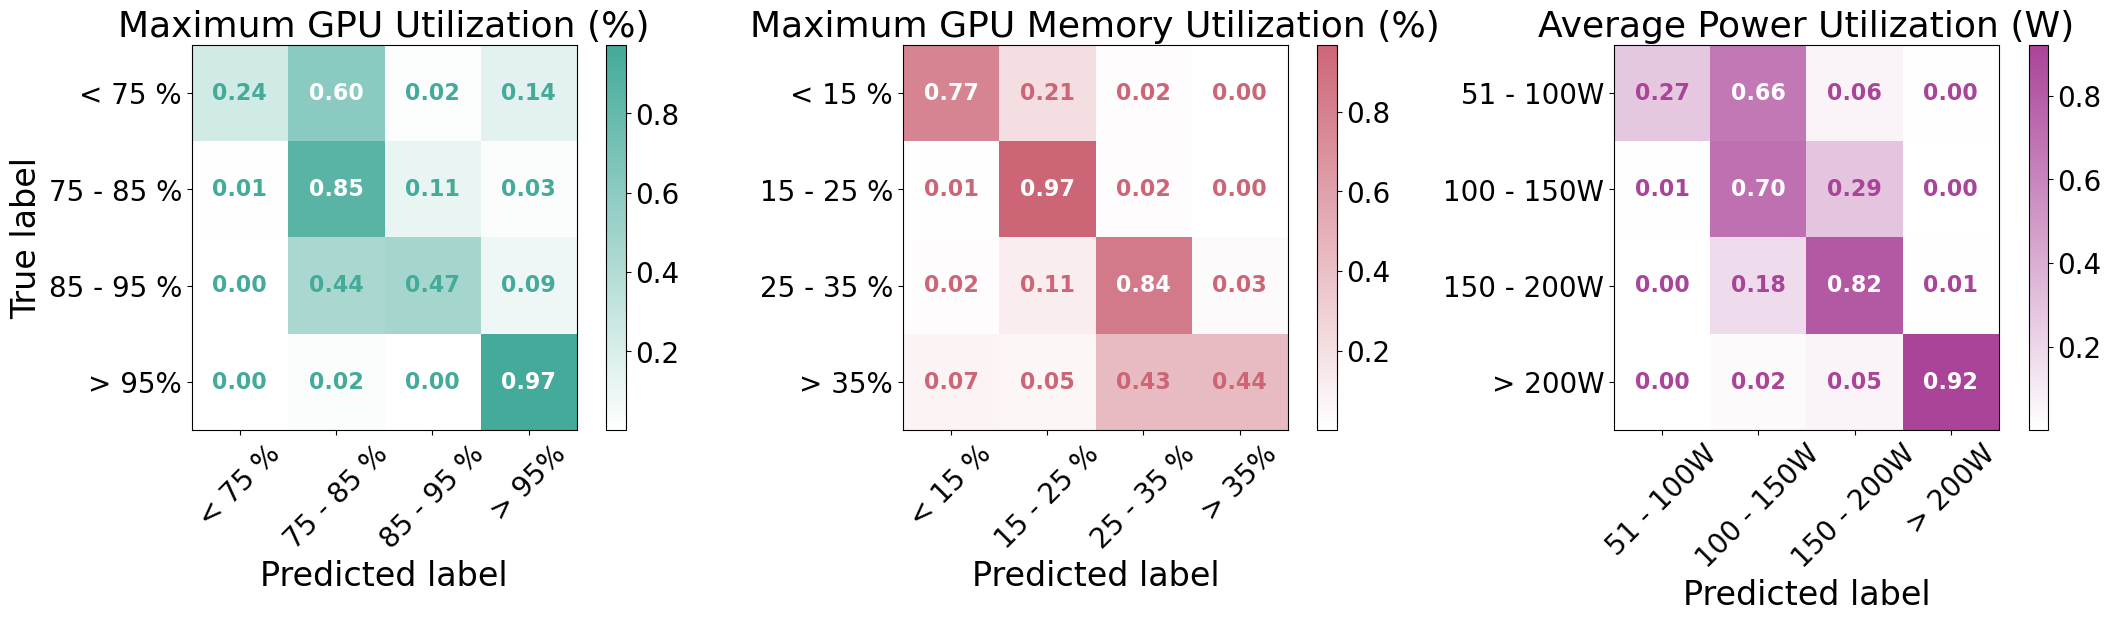

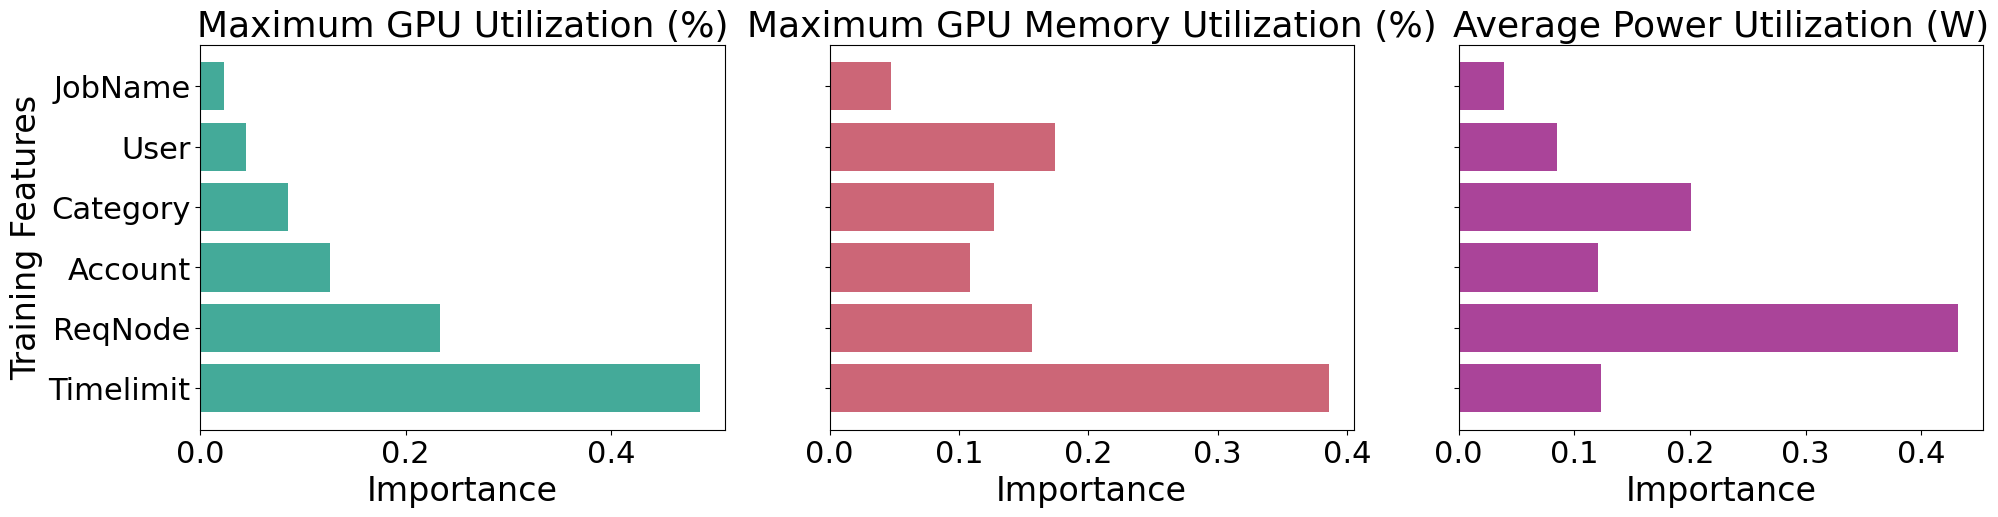

In [ ]:
df_ml = vasp_data.copy()
train_predict_classifier(df_ml, 'Confusion Matrix Prediction Results with Slurm Training Features', 'Feature Importance Results with Slurm Training Features')



Runtime Prediction Results

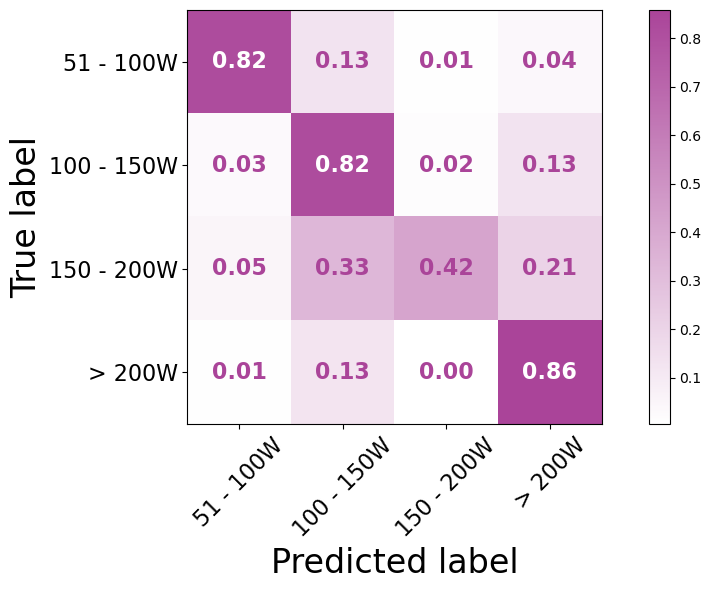

In [ ]:
cm = np.array([
    [ 37152,   5849,    502,   1769],
 [  4690, 129294,   2975,  20590],
 [  1158,   7884,   9952,   4927],
 [  1185,  15626,    593, 105717]
])

cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)



feature_importances = {
    'nersc_ldms_dcgm_power_usage_t1': 0.2146,
    'fb_used_t1': 0.0644,
    'req_time_t2': 0.0561 + 0.0346,
    'gpu_utilization_t1': 0.0508,
    'JobName_t2': 0.0502 + 0.0344,
    'nersc_ldms_dcgm_power_usage_t0': 0.0388,
    'gpu_utilization_t1': 0.0355,
    #'req_time_t1': 0.0346,
    #'JobName_t0': 0.0344,
    'AI_fp64_t0': 0.0340,
    'Account_t2': 0.0280,
    'req_node_t2': 0.0247
}

map_col_names = {
    'nersc_ldms_dcgm_power_usage_t1':  r'$avg\_power_{t-1}$',
    'fb_used_t1': r'$fb\_used_{t-1}$',
    'req_time_t2': 'Timelimit',
    'req_node_t2': 'ReqNode',
    'gpu_utilization_t1': r'$gpu\_utilization_{t-1}$',
    'JobName_t2': 'JobName',
    'Account_t2': 'Account',
    'nersc_ldms_dcgm_power_usage_t0':  r'$avg\_power_{t-2}$',
    'req_time_t1': 'Timelimit',
    'JobName_t0': 'JobName',
    'AI_fp64_t0': r'$AI\_fp64_{t-2}$',
    'sm_active_t1': r'$sm\_active_{t-1}$',
    'fb_used_t1': r'$fb\_used_{t-1}$',
    'req_node_t2': 'ReqNode',   
    'fb_used_t0': r'$fb\_used_{t-2}$'
}

# Sort by importance
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
sorted_importances = [f[1] for f in sorted_features]
mapped_features = [map_col_names.get(f[0], f[0]) for f in sorted_features]

class_labels = [0, 1, 2, 3]
label_names = ['51 - 100W', '100 - 150W', '150 - 200W', '> 200W']
cmap = make_single_color_cmap(colors['cmap3'], 'cmap3')


fig, ax1 = plt.subplots(1,1, figsize=(10,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=label_names)
disp.plot(cmap=cmap, values_format=".2f", ax=ax1, colorbar=True,
          text_kw={'fontsize': 16, 'fontweight': 'bold'})

#ax1.set_title('Average Power Utilization (W)', fontsize=26)
ax1.set_xlabel('Predicted label', fontsize=24)
ax1.set_ylabel('True label', fontsize=24)
ax1.tick_params(axis='both', labelsize=16)
for label in ax1.get_xticklabels():
    label.set_rotation(45)


plt.tight_layout()
plt.savefig("cm2.pdf", format='pdf', bbox_inches='tight')
plt.show()


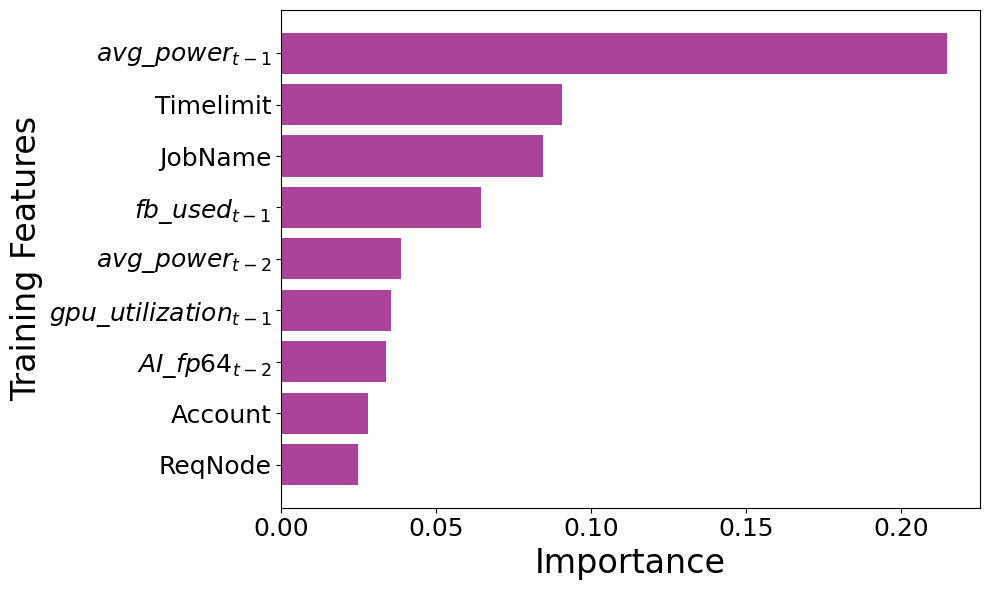

In [ ]:
fig, ax2 = plt.subplots(1,1, figsize=(10,6))
ax2.barh(mapped_features, sorted_importances, color=colors['cmap3'])
ax2.invert_yaxis()  # Highest importance on top
#ax2.set_title('Top Features', fontsize=26)
#ax2.set_title('Average Power Utilization (W)', fontsize=26)
ax2.set_xlabel('Importance', fontsize=24)
ax2.set_ylabel('Training Features', fontsize=24)
ax2.tick_params(axis='both', labelsize=18)

plt.tight_layout()
plt.savefig("feat2.pdf", format='pdf', bbox_inches='tight')
plt.show()